## Test the effect of mean normalization on the spectrograms

In [249]:
##### ##### CNN Parameters #####

batch_size = 10 
epochs = 30
mean_norm = True        # Flag to determine whether to use standard spectrograms or mean-normalized set
pad_images = False       # Resize images to a square by padding the end with gray (before resizing)
image_height_width = 112  # Resize all images to square with this height and width

###########################

In [7]:
# Load packages

import pandas as pd
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import IPython.display as ipd
from numpy.lib import stride_tricks
import os
from PIL import Image
import scipy.io.wavfile as wav

%matplotlib inline

## Create an additional set of mean-normalized spectrograms, denoted by "\_n" at the end of the filename  


The docstring for the short-time fourier transform matrix function says "_a matrix of this form can be passed as input to the CNN after undergoing normalization._". I'm not actually sure whether this is required / the correct way to do it, since the frequency is expressed in a log scale, but I thought we may as well check what happens

In [44]:
# Functions for processing

def stft(sig, frameSize, overlapFac=0.5, window=np.hanning):
    """
    Short-time Fourier transform of audio signal.
    """
    win = window(frameSize)
    hopSize = int(frameSize - np.floor(overlapFac * frameSize).astype(int))
    # zeros at beginning (thus center of 1st window should be for sample nr. 0)
    samples = np.append(np.zeros(np.floor(frameSize/2.0).astype(int)), sig)
    # cols for windowing
    cols = np.ceil((len(samples) - frameSize) / float(hopSize)).astype(int) + 1
    # zeros at end (thus samples can be fully covered by frames)
    samples = np.append(samples, np.zeros(frameSize))

    frames = stride_tricks.as_strided(samples, shape=(cols, frameSize),
                                      strides=(samples.strides[0]*hopSize,
                                      samples.strides[0])).copy()
    frames *= win

    return np.fft.rfft(frames)


def logscale_spec(spec, sr=44100, factor=20.):
    """
    Scale frequency axis logarithmically.
    """
    timebins, freqbins = np.shape(spec)
    
    scale = np.linspace(0, 1, freqbins) ** factor
    scale *= (freqbins-1)/max(scale)
    scale = np.unique(np.round(scale)).astype(int)
  
    # create spectrogram with new freq bins
    newspec = np.complex128(np.zeros([timebins, len(scale)]))
    for i in range(0, len(scale)):
        if i == len(scale)-1:
            newspec[:, i] = np.sum(spec[:, scale[i]:], axis=1)
        else:
            newspec[:, i] = np.sum(spec[:, scale[i]:scale[i+1]], axis=1)

    # list center freq of bins
    allfreqs = np.abs(np.fft.fftfreq(freqbins*2, 1./sr)[:freqbins+1])
    freqs = []
    for i in range(0, len(scale)):
        if i == len(scale)-1:
            freqs += [np.mean(allfreqs[scale[i]:])]
        else:
            freqs += [np.mean(allfreqs[scale[i]:scale[i+1]])]

    return newspec, freqs

# This is an adjusted version of the stft_matrix function that we used previously
def stft_matrix_norm(audiopath, binsize=2**10, png_name='tmp.png',
                save_png=False, offset=0):
    """
    A function that converts a wav file into a spectrogram represented by a \
    matrix where rows represent frequency bins, columns represent time, and \
    the values of the matrix represent the decibel intensity. A matrix of \
    this form can be passed as input to the CNN after undergoing normalization.
    """
    samplerate, samples = wav.read(audiopath)
    s = stft(samples, binsize)

    sshow, freq = logscale_spec(s, factor=1, sr=samplerate)
    ims = 20.*np.log10(np.abs(sshow)/10e-6)  # amplitude to decibel
    timebins, freqbins = np.shape(ims)

    ims = np.transpose(ims)
    ims = np.flipud(ims)
    ## Add a line to deduct the column mean from each point of the array
    ## to normalize the frequency of each time frame
    ims -= (np.mean(ims, axis=0) + 1e-8)

    if save_png:
        create_png(ims, png_name)

    return ims


def create_png(im_matrix, png_name):
    """
    Save grayscale png of spectrogram.
    """
    image = Image.fromarray(im_matrix)
    image = image.convert('L')  # convert to grayscale
    image.save(png_name)

In [45]:
# Location of source .wav files to convert. Each session has two recordings from two different microphones.

dir_names = ['../data/TORGO/F01/Session1',
            '../data/TORGO/F03/Session1','../data/TORGO/F03/Session2','../data/TORGO/F03/Session3',
            '../data/TORGO/F04/Session1','../data/TORGO/F04/Session2',
            '../data/TORGO/M01/Session1','../data/TORGO/M01/Session2_3',
            '../data/TORGO/M02/Session1','../data/TORGO/M02/Session2',
            '../data/TORGO/M03/Session2',
            '../data/TORGO/M04/Session1','../data/TORGO/M04/Session2',
            '../data/TORGO/M05/Session1','../data/TORGO/M05/Session2']
mics = ['wav_headMic','wav_arrayMic']

In [46]:
# Create mean normalized spectrograms

for d in dir_names:
    for m in mics:
        dir_name = d + '/' + m
        print('Processing directory ' + dir_name + '...')
        if not os.path.exists(dir_name + '_spect/'):
            os.makedirs(dir_name + '_spect/')
        for subdir, dirs, files in os.walk(dir_name):
            for file in files:
                if file.endswith('.wav'):
                    wav_file = os.path.join(subdir, file)
                    png_name = subdir + '_spect/' + file[:-4] + '_n.png'
                    try:
                        stft_matrix_norm(wav_file, png_name=png_name, save_png=True)
                    except:
                        print('WARNING: Unable to convert ' + file)
                        pass

print("Spectrogram Conversion Complete!")

Processing directory ../data/TORGO/F01/Session1/wav_headMic...
Processing directory ../data/TORGO/F01/Session1/wav_arrayMic...
Processing directory ../data/TORGO/F03/Session1/wav_headMic...
Processing directory ../data/TORGO/F03/Session1/wav_arrayMic...
Processing directory ../data/TORGO/F03/Session2/wav_headMic...
Processing directory ../data/TORGO/F03/Session2/wav_arrayMic...
Processing directory ../data/TORGO/F03/Session3/wav_headMic...
Processing directory ../data/TORGO/F03/Session3/wav_arrayMic...
Processing directory ../data/TORGO/F04/Session1/wav_headMic...
Processing directory ../data/TORGO/F04/Session1/wav_arrayMic...
Processing directory ../data/TORGO/F04/Session2/wav_headMic...
Processing directory ../data/TORGO/F04/Session2/wav_arrayMic...
Processing directory ../data/TORGO/M01/Session1/wav_headMic...
Processing directory ../data/TORGO/M01/Session1/wav_arrayMic...
Processing directory ../data/TORGO/M01/Session2_3/wav_headMic...
Processing directory ../data/TORGO/M01/Session

/Users/simonhodgkinson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in subtract


Processing directory ../data/TORGO/M02/Session1/wav_headMic...
Processing directory ../data/TORGO/M02/Session1/wav_arrayMic...
Processing directory ../data/TORGO/M02/Session2/wav_headMic...
Processing directory ../data/TORGO/M02/Session2/wav_arrayMic...
Processing directory ../data/TORGO/M03/Session2/wav_headMic...
Processing directory ../data/TORGO/M03/Session2/wav_arrayMic...
Processing directory ../data/TORGO/M04/Session1/wav_headMic...
Processing directory ../data/TORGO/M04/Session1/wav_arrayMic...
Processing directory ../data/TORGO/M04/Session2/wav_headMic...
Processing directory ../data/TORGO/M04/Session2/wav_arrayMic...
Processing directory ../data/TORGO/M05/Session1/wav_headMic...
Processing directory ../data/TORGO/M05/Session1/wav_arrayMic...
Processing directory ../data/TORGO/M05/Session2/wav_headMic...
Processing directory ../data/TORGO/M05/Session2/wav_arrayMic...
Spectrogram Conversion Complete!


## 1) Load and Filter Data

In [47]:
# Load master index, and filter and assign to train and test using pandas

# *** Load prompt_id as text with leading zeros
df = pd.read_csv('../index_TORGO.txt', sep="|", converters={'prompt_id': lambda x: str(x)})

# Remove instances where prompt is None OR prompts that begin with "[" or contain "jpg" OR where has_spect is No
df['remove'] = (df['prompt']==None) | (df['prompt']=='None') | (df['prompt'].str.contains('jpg')) | (df['prompt'].str.startswith('[')) | (df['has_spect']=='No')

print('Number of rows:', df.shape[0])
print('Number of rows set to remove:', df[df['remove']==True].shape[0])
df.head(20)

Number of rows: 6179
Number of rows set to remove: 523


,speaker,session,mic,prompt_id,has_spect,spect_width,spect_height,prompt,remove
0,F01,Session1,wav_headMic,0001,yes,320,513,[say Ah-P-Eee repeatedly],True
1,F01,Session1,wav_headMic,0002,yes,295,513,[say Ah-P-Eee repeatedly],True
2,F01,Session1,wav_headMic,0003,yes,242,513,[say Pah-Tah-Kah repeatedly],True
3,F01,Session1,wav_headMic,0004,yes,301,513,[say Eee-P-Ah repeatedly],True
4,F01,Session1,wav_headMic,0005,yes,240,513,[relax your mouth in its normal position],True
5,F01,Session1,wav_headMic,0006,yes,44,513,stick,False
6,F01,Session1,wav_headMic,0007,yes,71,513,tear [as in tear up that paper],False
7,F01,Session1,wav_headMic,0008,yes,308,513,Except in the winter when the ooze or snow or ...,False
8,F01,Session1,wav_headMic,0009,yes,40,513,pat,False
9,F01,Session1,wav_headMic,0010,yes,65,513,up,False


In [48]:
# Only keep instances where the recording was made on both the head and array mics
df = df[df['remove']==False]

df_head = df[(df['mic']=='wav_headMic')]
df_array = df[(df['mic']=='wav_arrayMic')]

df_filter = pd.merge(df_head, df_array, on=['speaker','session','prompt_id'])
print('Number of rows after filter and join in filter df:', df_filter.shape[0])
keep_id = df_filter['speaker'] + df_filter['session'] + df_filter['prompt_id']

df['keep_id'] = df['speaker'] + df['session'] + df['prompt_id']
df = df[df.keep_id.isin(keep_id)]
print('Number of rows after filter and join in df:', df.shape[0])  # Should be 2x the rows in the filter df

Number of rows after filter and join in filter df: 2471
Number of rows after filter and join in df: 4942


In [49]:
# Only keep instances where a prompt was recorded more than once

df_filter = df.groupby(['speaker','mic','prompt']).size().reset_index(name='counts')
df_filter = df_filter[df_filter['counts']>1]
keep_id = df_filter['speaker'] + df_filter['prompt']

df['keep_id'] = df['speaker'] + df['prompt']
df = df[df.keep_id.isin(keep_id)]
print('Number of rows after removing prompts only recorded once:', df.shape[0])

Number of rows after removing prompts only recorded once: 1422


In [50]:
df = df.sort_values(by=['speaker','prompt','prompt_id','mic'])
df.head(10)

,speaker,session,mic,prompt_id,has_spect,spect_width,spect_height,prompt,remove,keep_id
163,F01,Session1,wav_arrayMic,0030,yes,165,513,The quick brown fox jumps over the lazy dog.,False,F01The quick brown fox jumps over the lazy dog.
29,F01,Session1,wav_headMic,0030,yes,151,513,The quick brown fox jumps over the lazy dog.,False,F01The quick brown fox jumps over the lazy dog.
164,F01,Session1,wav_arrayMic,0031,yes,155,513,The quick brown fox jumps over the lazy dog.,False,F01The quick brown fox jumps over the lazy dog.
30,F01,Session1,wav_headMic,0031,yes,145,513,The quick brown fox jumps over the lazy dog.,False,F01The quick brown fox jumps over the lazy dog.
148,F01,Session1,wav_arrayMic,0015,yes,57,513,air,False,F01air
14,F01,Session1,wav_headMic,0015,yes,67,513,air,False,F01air
212,F01,Session1,wav_arrayMic,0079,yes,61,513,air,False,F01air
78,F01,Session1,wav_headMic,0079,yes,39,513,air,False,F01air
162,F01,Session1,wav_arrayMic,0029,yes,57,513,beat,False,F01beat
28,F01,Session1,wav_headMic,0029,yes,50,513,beat,False,F01beat


## 2) Listen to files that include the same prompt, to check what they sound like

In [51]:
# Array Mic, Sample 1
ipd.Audio('../data/TORGO/F01/Session1/wav_arrayMic/0030.wav')

In [14]:
# Array Mic, Sample 2
ipd.Audio('../data/TORGO/F01/Session1/wav_arrayMic/0031.wav')

In [15]:
# Head mic, Sample 1
ipd.Audio('../data/TORGO/F01/Session1/wav_headMic/0030.wav')

In [16]:
# Head mic, Sample 2
ipd.Audio('../data/TORGO/F01/Session1/wav_headMic/0031.wav')

It sounds as though the head mic and array mic are used simultaneously to capture the same speech, so the only difference is in the quality of the recording (the array mic includes higher levels of background noise). The second sample is a different recording (eg there is different intonation on the word "dog", with an upward inflection at the end)

## 3) Assign Data to Test and Train Sets

In [52]:
# Using the head Mic data, Sort the df by speaker, prompt, and prompt id
# Alternate assigning each row to train and test
# Then use that to join the assignment to the main dataframe, in order to tag the array Mic data with train/test

df_filter = df[df['mic']=='wav_headMic'].sort_values(by=['speaker','prompt','prompt_id'])

df_filter['train'] = 0
train = 1
for index, row in df_filter.iterrows():
    df_filter.at[index,'train'] = train
    train *= -1

df_filter = df_filter[['speaker','session','prompt_id','train']]

df = pd.merge(df, df_filter, on=['speaker','session','prompt_id'])

In [53]:
# *** FOR NOW ONLY USE FEMALE 1 *** We can alter this later
df = df[df['speaker']=='F01']

# Add numerical prompt codes once final data set is compiled
df.prompt = pd.Categorical(df.prompt)
df['prompt_code'] = df.prompt.cat.codes

df.head(80)

num_classes = df['prompt_code'].max() + 1
print('Number of rows for Female 1:', df.shape[0])
print('Number of unique prompts for Female 1: ', num_classes)

Number of rows for Female 1: 78
Number of unique prompts for Female 1:  18


## 4) Create required image lists - need to re-run this if you change the mean_norm flag

In [185]:
# Get all predictor variables (padded images) and outcome variable (prompt)
images = []
prompts = []
train = []

for index, row in df.iterrows():
    if mean_norm:
        img_loc = '/'.join(['../data/TORGO', row['speaker'], row['session'], row['mic']+'_spect', row['prompt_id']+'_n.png'])
    else:
        img_loc = '/'.join(['../data/TORGO', row['speaker'], row['session'], row['mic']+'_spect', row['prompt_id']+'.png'])
    img = cv2.imread(img_loc, 0)

    # Pad images before resize
    if pad_images:
        PADCOLOR = 132
        pad = maxwidth - img.shape[1] # pad width with gray
        img_new = cv2.copyMakeBorder(img,0,0,0,pad,cv2.BORDER_CONSTANT,value=PADCOLOR)
        pad = maxwidth - img.shape[0] # pad height with replication
        img_new = cv2.copyMakeBorder(img_new,0,pad,0,0,cv2.BORDER_WRAP)
        images.append(img_new)
    # Do not pad images before resize
    else:
        images.append(img)

    prompts.append(row['prompt_code'])
    train.append(row['train'])

In [186]:
# View first 10 records, and verify image sizes
print(prompts[0:10])
print(train[0:10])

for i in images[0:10]:
    print(i.shape)

[0, 0, 0, 0, 1, 1, 1, 1, 2, 2]
[1, 1, -1, -1, 1, 1, -1, -1, 1, 1]
(513, 165)
(513, 151)
(513, 155)
(513, 145)
(513, 57)
(513, 67)
(513, 61)
(513, 39)
(513, 57)
(513, 50)


(<matplotlib.axes._subplots.AxesSubplot at 0xb33236588>,
 <matplotlib.image.AxesImage at 0xb3386ff28>)

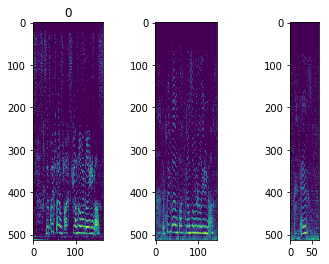

In [187]:
# See what they look like to visualize size and padding
plt.subplot(131), plt.imshow(images[0]), plt.title(prompts[0])
plt.subplot(132), plt.imshow(images[3])
plt.subplot(133), plt.imshow(images[5])


(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)


(<matplotlib.image.AxesImage at 0xb572a8748>,
 Text(0.5,1,'AFTER PADDING and SHRINK'))

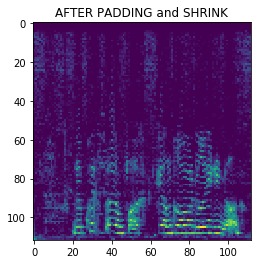

In [188]:
# Resize Images to image_height_width, which is set in the first cell of this workbook
maxwidth = image_height_width

images_shrunk = []
for i in images:
    images_shrunk.append(cv2.resize(i, (maxwidth, maxwidth)))

images = images_shrunk
for i in images[0:10]:
    print(i.shape)

plt.imshow(images[0]),plt.title('AFTER PADDING and SHRINK')

(<matplotlib.axes._subplots.AxesSubplot at 0xb57967710>,
 <matplotlib.image.AxesImage at 0xb53eae160>)

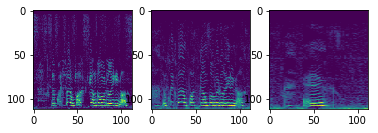

In [189]:
# See what they look like now, after rescaling
plt.subplot(131), plt.imshow(images[0])
plt.subplot(132), plt.imshow(images[3])
plt.subplot(133), plt.imshow(images[5])


## 4) Set up and run CNN

Recreated this CNN using Keras. [See here](https://adventuresinmachinelearning.com/keras-tutorial-cnn-11-lines/)

In [254]:
import keras
from keras import regularizers
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.models import Sequential
import matplotlib.pylab as plt

In [190]:
# Split data into training and testing
x_train_pre = np.array([images[i] for i,x in enumerate(train) if x==1])
y_train_pre = np.array([prompts[i] for i,x in enumerate(train) if x==1])
x_test_pre = np.array([images[i] for i,x in enumerate(train) if x==-1])
y_test_pre = np.array([prompts[i] for i,x in enumerate(train) if x==-1])

x_train = x_train_pre
y_train = y_train_pre
x_test = x_test_pre
y_test = y_test_pre

print('Number of training records:', len(y_train))
print('Number of test records:', len(y_test))

Number of training records: 40
Number of test records: 38


In [191]:
# input image dimensions
img_x, img_y = maxwidth, maxwidth

In [192]:
# reshape the data into a 4D tensor - (sample_number, x_img_size, y_img_size, num_channels)
# because it is in greyscale, we only have a single channel - RGB colour images would have 3
x_train = x_train.reshape(x_train.shape[0], img_x, img_y, 1)
x_test = x_test.reshape(x_test.shape[0], img_x, img_y, 1)
input_shape = (img_x, img_y, 1)

In [193]:
# convert the data to the right type
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (40, 112, 112, 1)
40 train samples
38 test samples


In [194]:
# convert class vectors to binary class matrices - this is for use in the
# categorical_crossentropy loss below
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [306]:
# Best model so far

model = Sequential()

# Convolution 1st layer
model.add(Conv2D(64, kernel_size=(6, 6), strides=(4, 4),
                 activation='relu',
                 padding = 'same',
                 input_shape=input_shape,
                 kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())  # ADDED THIS 1/30/19
#model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolution 2nd layer
model.add(Conv2D(32, (4, 4), activation='relu', padding = 'same',
                kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())  # ADDED THIS 1/30/19
#model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolution 3rd layer
model.add(Conv2D(16, (2, 2), activation='relu', padding = 'same',
                kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())  # ADDED THIS 1/30/19
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fully connected layer 1
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())  # ADDED THIS 1/30/19

# # Fully connected layer 2
# model.add(Dense(100, activation='relu'))
# model.add(Dropout(0.2))
# model.add(BatchNormalization()) 

# Fully connected layer 3
model.add(Dense(num_classes, activation='softmax'))

In [307]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [66]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []
        self.val_acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))

In [308]:
history = AccuracyHistory()

In [309]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[history])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 40 samples, validate on 38 samples
Epoch 1/30
40/40 [==============================] - 8s 203ms/step - loss: 4.2082 - acc: 0.0000e+00 - val_loss: 4.1012 - val_acc: 0.0789
Epoch 2/30
40/40 [==============================] - 0s 10ms/step - loss: 2.4209 - acc: 0.5500 - val_loss: 3.2961 - val_acc: 0.2368
Epoch 3/30
40/40 [==============================] - 0s 10ms/step - loss: 2.0914 - acc: 0.6750 - val_loss: 3.2310 - val_acc: 0.2632
Epoch 4/30
40/40 [==============================] - 0s 10ms/step - loss: 1.6496 - acc: 0.8000 - val_loss: 3.1514 - val_acc: 0.1842
Epoch 5/30
40/40 [==============================] - 0s 10ms/step - loss: 1.3595 - acc: 0.9250 - val_loss: 3.1504 - val_acc: 0.2632
Epoch 6/30
40/40 [==============================] - 0s 10ms/step - loss: 1.2900 - acc: 0.9750 - val_loss: 3.1435 - val_acc: 0.2368
Epoch 7/30
40/40 [==============================] - 0s 10ms/step - loss: 1.1004 - acc: 1.0000 - val_loss: 3.1597 - val_acc: 0.2368
Epoch 8/30
40/40 [================

With mean normalization
Test loss: 2.9015808481919136
Test accuracy: 0.3421052662949813


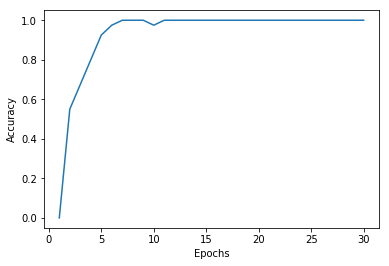

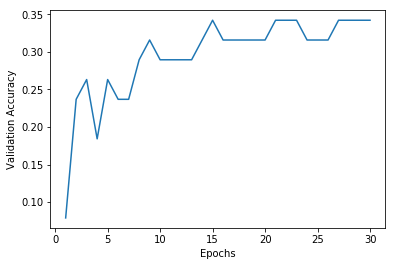

In [310]:
# Results with mean normalization

print('With mean normalization')
print('Test loss:', score[0])
print('Test accuracy:', score[1])

plt.plot(range(1, epochs + 1), history.acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()
plt.plot(range(1, epochs + 1), history.val_acc)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.show()

Without mean normalization
Test loss: 2.97115421295166
Test accuracy: 0.21052631657374532


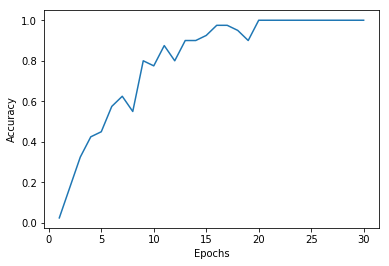

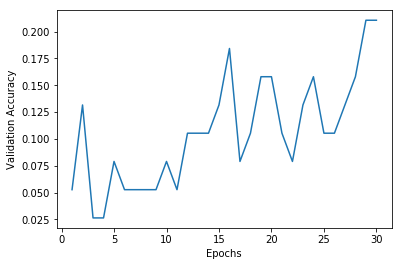

In [183]:
# Results without mean normalization

print('Without mean normalization')
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plt.plot(range(1, epochs + 1), history.acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()
plt.plot(range(1, epochs + 1), history.val_acc)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.show()

### Notes on results:

Better accuracy after 30 epochs, but still caps out at about 30% though - best result was 39% but with additional FC layer and dropout of 30% in each. That config only worked for the mean norm data (for the unadjusted data, accuracy was about 5%)